# Relation Networks for VQA

In [1]:
import mxnet as mx
from mxnet import gluon, autograd, nd
from mxnet.gluon import nn,utils
from mxnet.gluon.data import ArrayDataset, DataLoader
import numpy as np
import os, sys, time
from tqdm import tqdm
import pickle
import random
from tqdm import tnrange, tqdm_notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import pandas as pd
%matplotlib inline

In [2]:
mx.__version__

'1.3.0'

## Data Preparation

In [3]:
##generate input data
!python sort_of_clevr_gen.py

directory ./data already exists
building test datasets...
building train datasets...
saving datasets...
datasets saved at ./data/sort-of-clevr.pickle


## Model Definition

In [4]:
GPU_COUNT = 2 # Set gpu count
def setting_ctx(GPU_COUNT):
    if GPU_COUNT > 0 :
        ctx = [mx.gpu(i) for i in range(GPU_COUNT)]
    else :
        ctx = [mx.cpu()]
    return ctx
        
ctx = setting_ctx(GPU_COUNT)

In [5]:
class ConvInputModel(nn.HybridSequential):
    def __init__(self,**kwargs):
        super(ConvInputModel,self).__init__(**kwargs)                
        with self.name_scope():
            self.add(
                nn.Conv2D(channels=24, kernel_size=3, strides=2, padding=1, activation='relu'),
                nn.BatchNorm(),
                nn.Conv2D(channels=24, kernel_size=3, strides=2, padding=1, activation='relu'),
                nn.BatchNorm(),
                nn.Conv2D(channels=24, kernel_size=3, strides=2, padding=1, activation='relu'),
                nn.BatchNorm(),
                nn.Conv2D(channels=24, kernel_size=3, strides=2, padding=1, activation='relu'),
                nn.BatchNorm()
            )

In [6]:
class FCOutputModel(nn.HybridSequential):
    def __init__(self,**kwargs):
        super(FCOutputModel,self).__init__(**kwargs)
        
        with self.name_scope():
            self.add(
                nn.Dense(256, activation='relu'),
                nn.Dropout(0.5),
                nn.Dense(10)
            )

In [30]:
class RN_Model(nn.HybridBlock):
    def __init__(self, **kwargs):
        super(RN_Model, self).__init__(**kwargs)
    
        with self.name_scope():
            self.conv = ConvInputModel()
            
            self.g_fc1 = nn.Dense(256, activation='relu', flatten=False)
            self.g_fc2 = nn.Dense(256, activation='relu', flatten=False)
            self.g_fc3 = nn.Dense(256, activation='relu', flatten=False)
            self.g_fc4 = nn.Dense(256, activation='relu', flatten=False)
            
            self.f_fc1 = nn.Dense(256, activation='relu')
            self.fcout = FCOutputModel()
            

    def hybrid_forward(self, F, x, qst, coord_tensor):
        
        #input size = (64 * 3 * 75 * 75)
        x = self.conv(x) ## x = (64 * 24 * 5 * 5)
                
        
        x_flat = x.reshape(shape=(0, 0, -3))
        x_flat = F.swapaxes(x_flat,1,2) ## (64 * 25 * 24)
        
        ##add coordinates
        x_flat = F.concat(x_flat, coord_tensor,dim=2)
        
        ##add question
        qst = qst.expand_dims(1)
        qst = F.repeat(qst,repeats=25,axis=1)
        qst = qst.expand_dims(2)
        
        # cast all pairs against each other
        x_i = x_flat.expand_dims(1)
        x_i = F.repeat(x_i,repeats=25,axis=1)
        
        x_j = x_flat.expand_dims(2)
        x_j = F.concat(x_j,qst,dim=3)
        x_j = F.repeat(x_j,repeats=25,axis=2)
        
        #concatenate all
        x_full = F.concat(x_i,x_j,dim=3)
        
        x_ = self.g_fc1(x_full.reshape((0, -1, 63)))
        x_ = self.g_fc2(x_)
        x_ = self.g_fc3(x_)
        x_ = self.g_fc4(x_)
        
        x_g = x_.sum(1)

        
        ##### f part #######
        x_f = self.f_fc1(x_g)


        
        return self.fcout(x_f)
            

## Data Loading

In [9]:
def load_data():
    print('loading data...')
    dirs = os.getcwd()
    filename = os.path.join(dirs,'data','sort-of-clevr.pickle')
    with open(filename, 'rb') as f:
        train_datasets, test_datasets = pickle.load(f)
    rel_train = []
    rel_test = []
    norel_train = []
    norel_test = []
    print('processing data...')

    for img, relations, norelations in train_datasets:
        img = np.swapaxes(img,0,2)
        for qst,ans in zip(relations[0], relations[1]):
            rel_train.append((img,qst,ans))
        for qst,ans in zip(norelations[0], norelations[1]):
            norel_train.append((img,qst,ans))

    for img, relations, norelations in test_datasets:
        img = np.swapaxes(img,0,2)
        for qst,ans in zip(relations[0], relations[1]):
            rel_test.append((img,qst,ans))
        for qst,ans in zip(norelations[0], norelations[1]):
            norel_test.append((img,qst,ans))
    
    return (rel_train, rel_test, norel_train, norel_test)

In [10]:
##load input data
rel_train, rel_test, norel_train, norel_test = load_data()

loading data...
processing data...


In [11]:
def display_image(data):
    img = data[0]
    img = np.swapaxes(img,0,2)
    plt.imshow((img * 255.0).astype('uint8'))

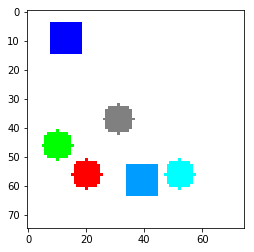

In [12]:
display_image(rel_train[20])

## Model Training

In [13]:
##setting hyper-parameters
args = dict()
args['batch_size'] = 128
args['epochs'] = 50

### Network

In [31]:
model = RN_Model()
#parameter initialozation
model.collect_params().initialize(mx.init.Xavier(magnitude=2.3), ctx=ctx)

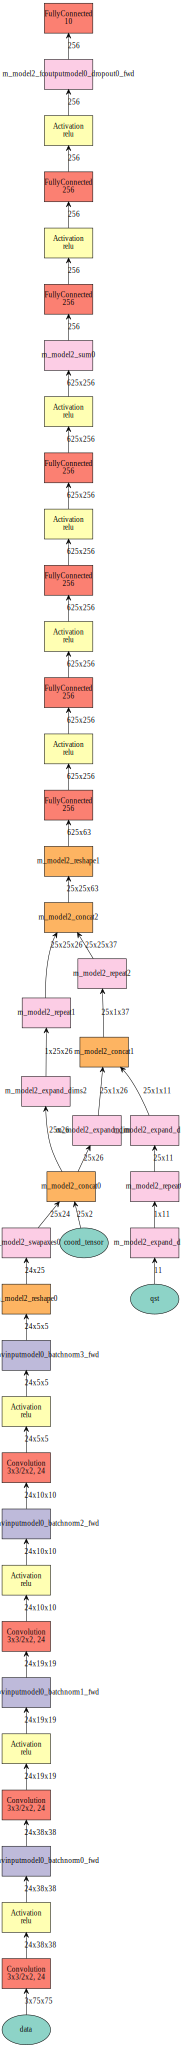

In [32]:
mx.viz.plot_network(model(mx.sym.var('data'), mx.sym.var('qst'), mx.sym.var('coord_tensor')), shape={'data':(128,3,75,75), 'qst':(128,11), 'coord_tensor': (128, 25, 2)})

### Trainer

In [33]:
#set optimizer
trainer = gluon.Trainer(model.collect_params(),optimizer='adam',optimizer_params={'learning_rate':0.0001})

### Loss

In [34]:
#define loss function
loss = gluon.loss.SoftmaxCrossEntropyLoss()

### Helper functions

In [35]:
# prepare coord tensor
def cvt_coord(i):
    return [(i/5-2)/2., (i%5-2)/2.]

In [36]:
def cvt_data_axis_nd(data):
    img = [e[0] for e in data]
    qst = [e[1] for e in data]
    ans = [e[2] for e in data]
    return (nd.array(img), nd.array(qst), nd.array(ans))

### Evaluation metric

In [37]:
def evaluate_accuracy(data,  model, ctx):
    acc_rel = mx.metric.Accuracy()
    acc_norel = mx.metric.Accuracy()
    for i, (rel_img, rel_qst, rel_label, norel_img, norel_qst, norel_label) in enumerate(data):

        rel_img = rel_img.as_in_context(ctx)
        rel_qst = rel_qst.as_in_context(ctx)
        rel_label = rel_label.as_in_context(ctx)
        
        norel_img = norel_img.as_in_context(ctx)
        norel_qst = norel_qst.as_in_context(ctx)
        norel_label = norel_label.as_in_context(ctx)

        output = model(rel_img, rel_qst, coord_tensors[0])        
        predictions = nd.argmax(output,axis=1)        
        acc_rel.update(preds=predictions, labels=rel_label)

        output = model(norel_img, norel_qst, coord_tensors[0])        
        predictions = nd.argmax(output,axis=1)        
        acc_norel.update(preds=predictions, labels=norel_label)

    return acc_rel, acc_norel

### Data Loading

In [21]:
rel_train_nd = cvt_data_axis_nd(rel_train)
rel_test_nd = cvt_data_axis_nd(rel_test)
norel_train_nd = cvt_data_axis_nd(norel_train)
norel_test_nd = cvt_data_axis_nd(norel_test)

In [22]:
batchsize = args['batch_size']*GPU_COUNT if GPU_COUNT > 0 else args['batch_size']

In [23]:
train_dataset = ArrayDataset(rel_train_nd[0], rel_train_nd[1], rel_train_nd[2], norel_train_nd[0], norel_train_nd[1], norel_train_nd[2])
test_dataset = ArrayDataset(rel_test_nd[0], rel_test_nd[1], rel_test_nd[2], norel_test_nd[0], norel_test_nd[1], norel_test_nd[2])

dataloader_train = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, last_batch='discard', num_workers=5)
dataloader_test = DataLoader(test_dataset, batch_size=args['batch_size'], shuffle=False, last_batch='discard', num_workers=5)

In [24]:
# Prepare coord_tensor
coord_tensor = nd.zeros((batchsize, 25, 2))
for i in range(25):
     coord_tensor[:,i,:] = nd.array(cvt_coord(i))
        
coord_tensors = gluon.utils.split_and_load(coord_tensor,ctx)

## Training loop

In [38]:
model.hybridize()

In [ ]:
rel_loss = list()
norel_loss =  list()
rel_acc = list()
norel_acc = list()

for epoch in range(args['epochs']):
    cumulative_rel_loss = 0.0
    cumulative_norel_loss = 0.0
    tick = time.time()
    
    for i, (rel_img, rel_qst, rel_label, norel_img, norel_qst, norel_label) in enumerate(dataloader_train):

        # Relational data        
        rel_imgs = gluon.utils.split_and_load(rel_img, ctx)
        rel_qsts = gluon.utils.split_and_load(rel_qst, ctx)
        rel_labels = gluon.utils.split_and_load(rel_label, ctx)
        
        # No-relationtional data       
        norel_imgs = gluon.utils.split_and_load(norel_img, ctx)
        norel_qsts = gluon.utils.split_and_load(norel_qst, ctx)
        norel_labels = gluon.utils.split_and_load(norel_label, ctx)        

        with autograd.record():
            rel_losses = [loss(model(X,Y, coord),Z) for X, Y, coord, Z in zip(rel_imgs, rel_qsts, coord_tensors, rel_labels )]
        for l in rel_losses:
            l.backward()
            
        trainer.step(rel_img.shape[0])
        
        for l in rel_losses:
            cumulative_rel_loss += l.mean().asscalar()
        
        with autograd.record():
            norel_losses = [loss(model(X,Y, coord),Z) for X, Y, coord, Z in zip(norel_imgs, norel_qsts, coord_tensors, norel_labels)]
        for l in norel_losses:
            l.backward()
            
        trainer.step(norel_img.shape[0])
        
        for l in norel_losses:
                cumulative_norel_loss += l.mean().asscalar()
        
    mx.nd.waitall()
    acc_rel, acc_norel = evaluate_accuracy(dataloader_test, model, mx.gpu(0))
    print("[{}], Rel loss: {:.4f}, NoRel loss {:.4f}, Acc Rel {:.4f}, Acc NoRel {:.4f}. {:.4f}sec".format(
        epoch, cumulative_rel_loss/len(dataloader_train), cumulative_norel_loss/len(dataloader_train), 
        acc_rel.get()[1], acc_norel.get()[1], time.time()-tick))
    
    rel_loss.append(cumulative_rel_loss/len(dataloader_train))
    norel_loss.append(cumulative_norel_loss/len(dataloader_train))
    rel_acc.append(acc_rel.get()[1])
    norel_acc.append(acc_norel.get()[1])

[0], Rel loss: 0.1424, NoRel loss 0.0033, Acc Rel 0.8906, Acc NoRel 0.9844. 23.0805sec
[1], Rel loss: 0.1408, NoRel loss 0.0036, Acc Rel 0.8938, Acc NoRel 0.9849. 23.0171sec
[2], Rel loss: 0.1344, NoRel loss 0.0049, Acc Rel 0.8990, Acc NoRel 0.9833. 23.0294sec
[3], Rel loss: 0.1268, NoRel loss 0.0037, Acc Rel 0.8844, Acc NoRel 0.9875. 22.9431sec
[4], Rel loss: 0.1193, NoRel loss 0.0028, Acc Rel 0.8880, Acc NoRel 0.9859. 22.9057sec


## Metrics

In [46]:
perf_metric = collections.OrderedDict()

In [47]:
perf_metric['epoch'] = np.arange(args['epochs'])+1
perf_metric['rel_loss'] = np.array(rel_loss)
perf_metric['no_rel_loss'] =np.array(norel_loss)
perf_metric['rel_acc'] = np.array(rel_acc)
perf_metric['no_rel_acc'] = np.array(norel_acc)

In [48]:
perf_metric = pd.DataFrame(perf_metric)

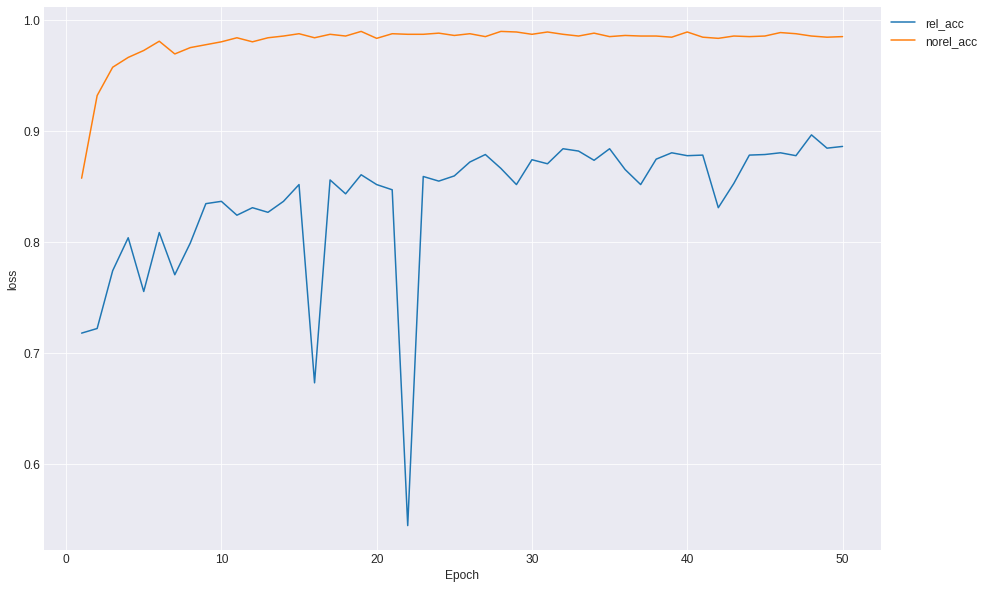

In [49]:
plt.rcParams.update({'font.size': 12})
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')
plt.figure(figsize=(15,10))
plt.xlabel("Epoch")
plt.ylabel("loss")

plt.plot(np.arange(args['epochs'])+1,  np.array(rel_acc),label="rel_acc")
plt.plot(np.arange(args['epochs'])+1, np.array(norel_acc),label="norel_acc")
plt.legend(bbox_to_anchor=(1, 1), loc=2,)
plt.show()

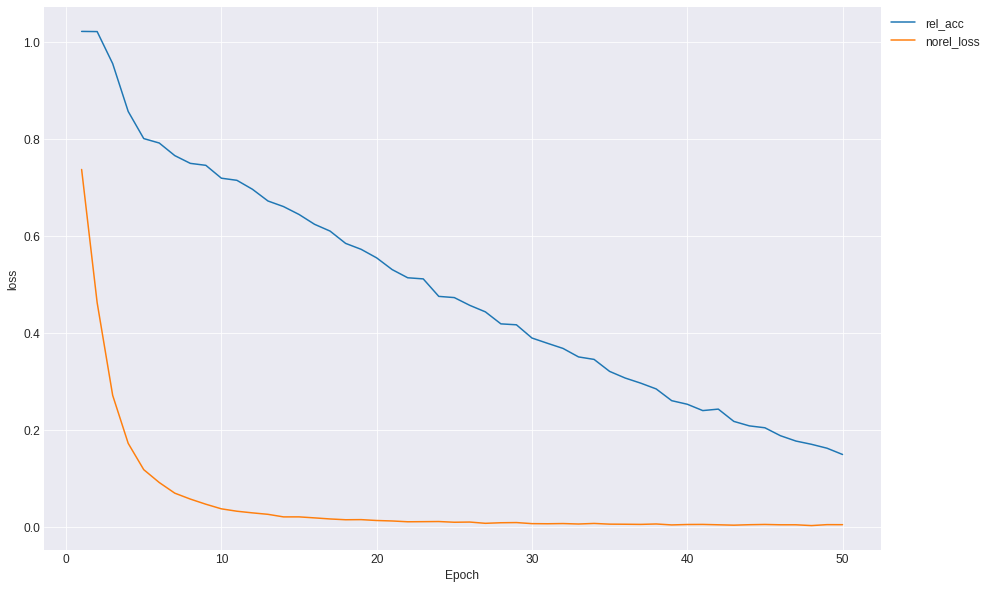

In [50]:
plt.rcParams.update({'font.size': 12})
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')
plt.figure(figsize=(15,10))
plt.xlabel("Epoch")
plt.ylabel("loss")

plt.plot(np.arange(args['epochs'])+1,  np.array(rel_loss),label="rel_acc")
plt.plot(np.arange(args['epochs'])+1, np.array(norel_loss),label="norel_loss")
plt.legend(bbox_to_anchor=(1, 1), loc=2,)
plt.show()